### Loan Approval Prediction using Machine Learning

The purpose of this project was to develop a machine learning model that can predict whether a person is likely to get approved for a loan or not. The project utilized data from a public dataset that contains information on loan applicants, including their income, loan amount, credit history, and other relevant factors. The project began with exploratory data analysis to identify the most important features for the model. The project then used logistic regression to train and test the machine learning model, achieving an accuracy of 79% and a precision of 76%. The project also included the creation of a confusion matrix and a classification report to provide insights into the performance of the model. Overall, this project demonstrates the potential of machine learning to help automate the loan approval process and make it more efficient and accurate.

#### Loading dataset into Spark cluster >>>

In [0]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('loanPrediction').getOrCreate()

# File location and type
file_location = "/FileStore/tables/train_u6lujuX_CVtuZ9i-3.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df0 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df0.show(10))

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

#### Data preparation >>>

In [0]:
# Move table from SparkFrame to Pandas DF and dropping 'Loan_ID' column as it's not necessery 

import pandas as pd
df = df0.toPandas().drop('Loan_ID', axis=1)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [0]:
# Check data types in table and fullness verification

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int32  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int32(1), object(7)
memory usage: 55.3+ KB


In [0]:
# Credit_History column should be stored as boolean, the rest looks fine

df['Credit_History'] = df['Credit_History'].astype(bool)

In [0]:
# Check how many values we're missing

for x in df.columns:
    a= df[x].to_frame().value_counts().sum()
    print(x,a)

Gender 601
Married 611
Dependents 599
Education 614
Self_Employed 582
ApplicantIncome 614
CoapplicantIncome 614
LoanAmount 592
Loan_Amount_Term 600
Credit_History 614
Property_Area 614
Loan_Status 614


In [0]:
# Get some statistic insights from numerical columns

df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


In [0]:
# Check for missing values

df.isna().sum()


Out[181]: Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [0]:
# Separate columns into 3 categories, what will be crucial in next steps

numerical_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()
boolean_cols = df.select_dtypes(include='bool').columns.tolist()

all_cols=numerical_cols+categorical_cols+boolean_cols

In [0]:
# Fill n/a values using population mean or most popular value depends on data category

for col in numerical_cols:
        mean = df[col].mean()
        df[col].fillna(mean,inplace=True)
for col in categorical_cols:
        moda = df[col].value_counts().idxmax()
        df[col].fillna(moda,inplace=True)


In [0]:
# Check for missing values again
df.isna().sum()

Out[184]: Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [0]:
# Check for duplicate rows:

duplicate_rows = df.duplicated()
duplicate_rows.value_counts()

Out[185]: False    614
dtype: int64

#### Data analysis >>>

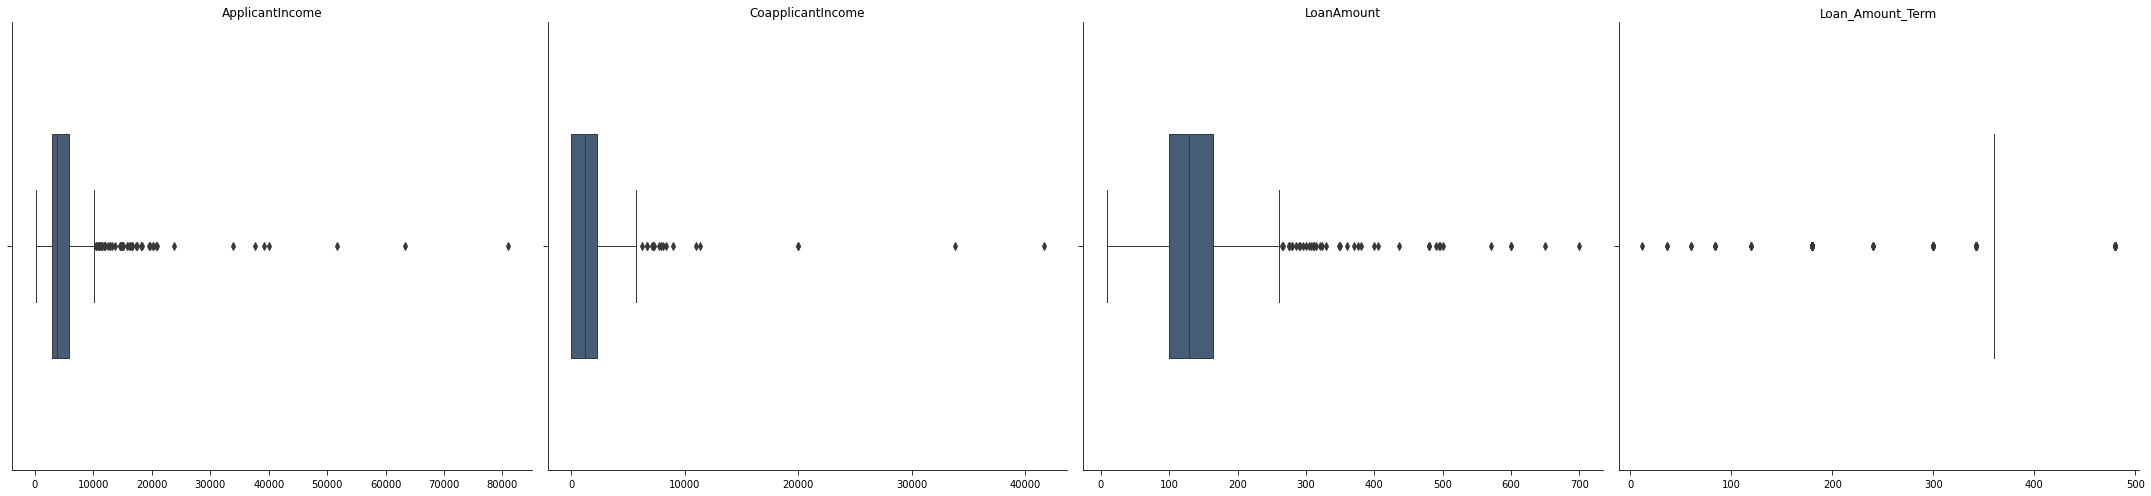

In [0]:
# Check for outliers: 
# 1st method: Box-plot
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=len(numerical_cols), figsize=(30,7))

for i, x in enumerate(numerical_cols):
    sns.boxplot(x=df[x], ax=axs[i], color='#3F5D7D', width=0.5, linewidth=1)
    axs[i].set_title(x, fontsize=12)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].tick_params(axis='both', which='major', labelsize=10, length=5)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

plt.tight_layout()

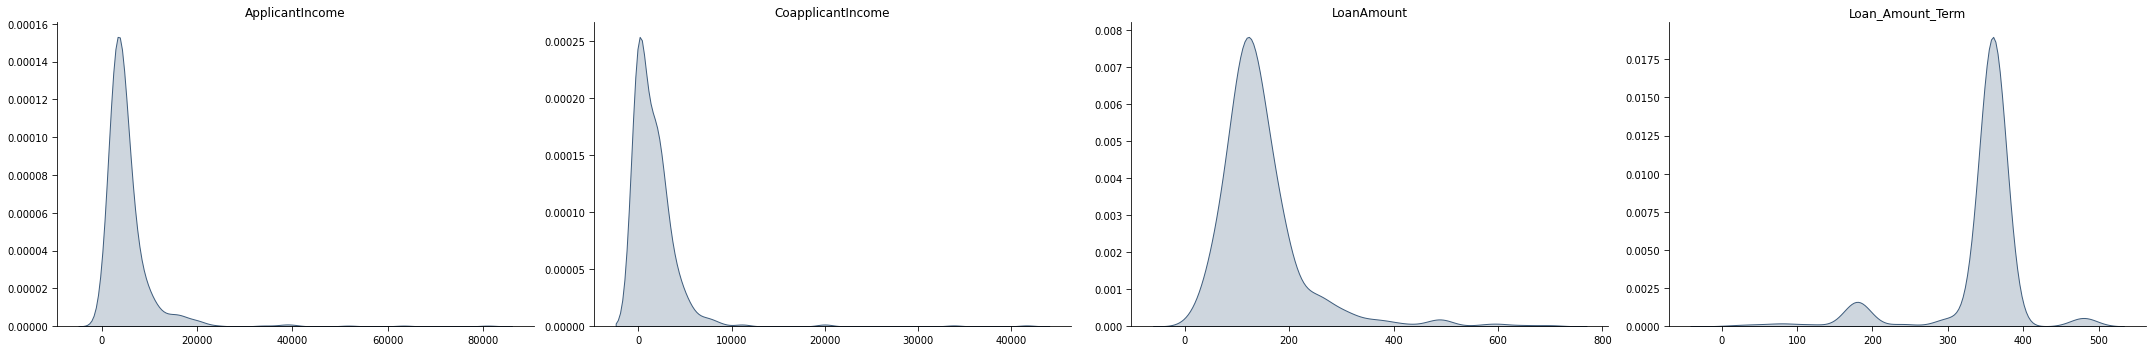

In [0]:
# 2nd method: Density plot

fig, axs = plt.subplots(ncols=len(numerical_cols), figsize=(30,5))

for i, x in enumerate(numerical_cols):
    sns.kdeplot(df[x], ax=axs[i], shade=True, color='#3F5D7D')
    axs[i].set_title(x, fontsize=12)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].tick_params(axis='both', which='major', labelsize=10, length=5)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

plt.tight_layout()

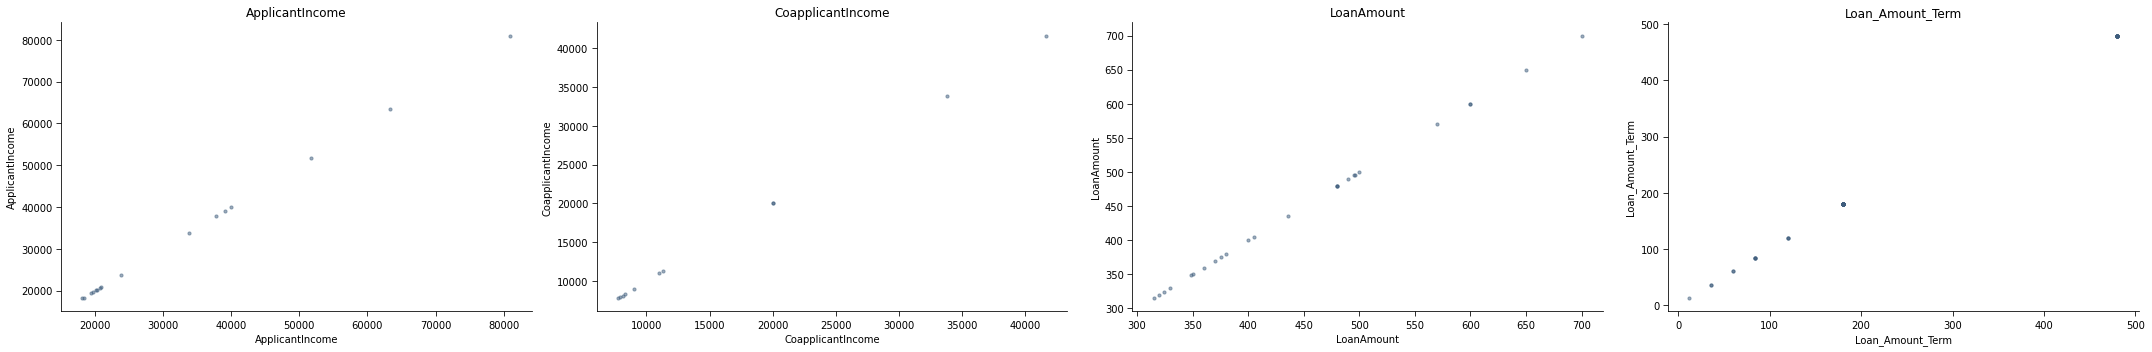

In [0]:
# 3rd method: Z-score parameter calculation

import numpy as np

fig, axs = plt.subplots(ncols=len(numerical_cols), figsize=(30,5))

for i, x in enumerate(numerical_cols):
    z_scores = np.abs((df[x] - df[x].mean()) / df[x].std())
    outliers = df[z_scores > 2]
    
    axs[i].scatter(outliers[x], outliers[x], s=10, alpha=0.5, color='#3F5D7D')
    axs[i].set_title(x, fontsize=12)
    axs[i].set_xlabel(x, fontsize=10)
    axs[i].set_ylabel(x, fontsize=10)
    axs[i].tick_params(axis='both', which='major', labelsize=10, length=5)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    
plt.tight_layout()

In [0]:
# Check distinct values in categorical and boolean columns

for x in categorical_cols+boolean_cols:
        print(x , df[x].unique())

Gender ['Male' 'Female']
Married ['No' 'Yes']
Dependents ['0' '1' '2' '3+']
Education ['Graduate' 'Not Graduate']
Self_Employed ['No' 'Yes']
Property_Area ['Urban' 'Rural' 'Semiurban']
Loan_Status ['Y' 'N']
Credit_History [ True False]


In [0]:
# Convert categorical variables to numerical form using LabelEncoder

from sklearn.preprocessing import LabelEncoder

# Loop through each categorical column
for col in categorical_cols+boolean_cols:
    # Create an instance of LabelEncoder
    le = LabelEncoder()
    # Fit and transform the data for the current column
    df[col] = le.fit_transform(df[col])
    # Print the mapping between original values and encoded labels 
    print(col + ": " + str(dict(zip(le.classes_, le.transform(le.classes_))))) 

Gender: {'Female': 0, 'Male': 1}
Married: {'No': 0, 'Yes': 1}
Dependents: {'0': 0, '1': 1, '2': 2, '3+': 3}
Education: {'Graduate': 0, 'Not Graduate': 1}
Self_Employed: {'No': 0, 'Yes': 1}
Property_Area: {'Rural': 0, 'Semiurban': 1, 'Urban': 2}
Loan_Status: {'N': 0, 'Y': 1}
Credit_History: {False: 0, True: 1}


#### Feature scaling >>>

In [0]:
from sklearn.preprocessing import StandardScaler

# select the numerical columns
scale_cols = ['LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome']

# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler object to the numerical columns
scaler.fit(df[scale_cols])

# transform the numerical columns
df[scale_cols] = scaler.transform(df[scale_cols])

df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,0.072991,-0.554487,0.000000,0.279851,1,2,1
1,1,1,1,0,0,-0.134412,-0.038732,-0.219273,0.279851,1,0,0
2,1,1,0,0,1,-0.393747,-0.554487,-0.957641,0.279851,1,2,1
3,1,1,0,1,0,-0.462062,0.251980,-0.314547,0.279851,1,2,1
4,1,0,0,0,0,0.097728,-0.554487,-0.064454,0.279851,1,2,1


#### Feature selection >>>

Out[192]: <AxesSubplot:>

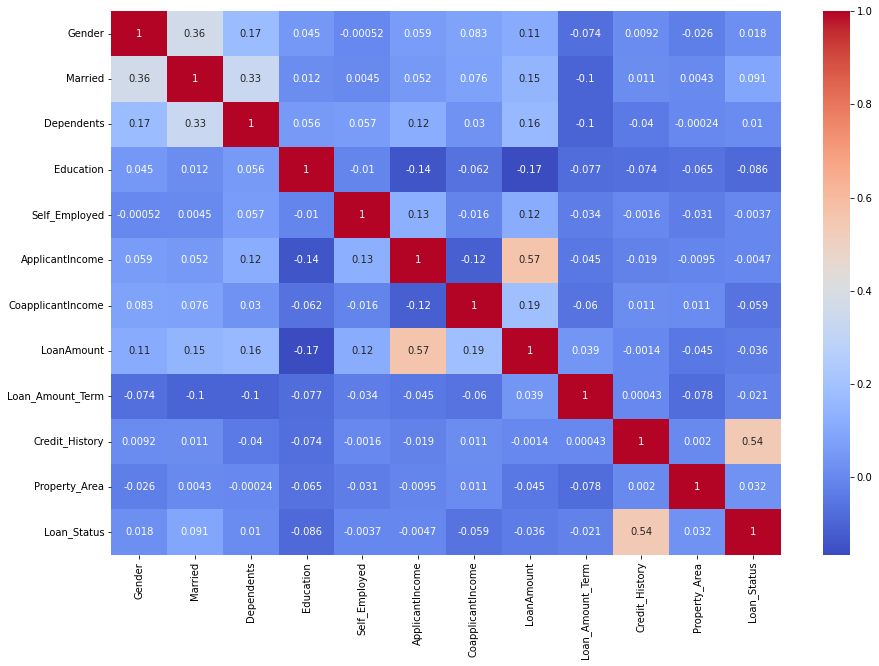

In [0]:
import seaborn as sns

# calculate the correlation matrix
corr = df.corr()

# plot the correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [0]:
corr_matrix = df.corr()

# Convert correlation matrix to DataFrame
corr_df = pd.DataFrame(corr_matrix)

# Sort correlation table by absolute values in descending order
corr_sorted = corr_df.abs().unstack().sort_values(ascending=False).reset_index()
corr_sorted = corr_sorted[corr_sorted['level_0'] != corr_sorted['level_1']]
corr_sorted.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Print sorted correlation table
corr_sorted.head(10)

,Feature 1,Feature 2,Correlation
12,ApplicantIncome,LoanAmount,0.565620
13,LoanAmount,ApplicantIncome,0.565620
14,Loan_Status,Credit_History,0.540556
15,Credit_History,Loan_Status,0.540556
16,Married,Gender,0.364569
17,Gender,Married,0.364569
18,Married,Dependents,0.334216
19,Dependents,Married,0.334216
20,LoanAmount,CoapplicantIncome,0.187828
21,CoapplicantIncome,LoanAmount,0.187828


#### Model selection and train_test_split >>>

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X = df[['ApplicantIncome', 'LoanAmount', 'CoapplicantIncome', 'Credit_History']]
y = df['Loan_Status']
lr=LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lr.fit(X_train,y_train)
score= lr.score(X_test,y_test)
y_pred=lr.predict(X_test)
accuracy= accuracy_score(y_test,y_pred)

print('Accuracy:', accuracy)
print(confusion_matrix(y_test,y_pred))

Accuracy: 0.7886178861788617
[[18 25]
 [ 1 79]]


#### Conclusion >>>

There was 18 true negative predictions and 79 true positive predictions, which means that the model correctly predicted the outcomes for 97 loan applications. However, there were 25 false positive predictions, which means that the model predicted loan approval but it was not approved, and 1 false negative prediction, which means that the model predicted loan denial but it was actually approved.

Overall, the model seems to be performing well with a high number of true positives and true negatives, but there is still some room for improvement to reduce the number of false positive and false negative predictions.

In [0]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



#### Model Performance >>>
We trained a logistic regression model using four features (ApplicantIncome, LoanAmount, CoapplicantIncome, and Credit_History) to predict whether a loan application will be approved or not. The model achieved an accuracy of 0.79 on the test set.

The confusion matrix shows that the model correctly predicted 79 out of 80 loan approvals (true positives) and 18 out of 43 loan rejections (true negatives). However, it incorrectly predicted 25 loan rejections as approvals (false positives) and 1 loan approval as rejection (false negative).

The precision of the model is 0.76, which means that out of all the loan approvals predicted by the model, 76% were actually approved. The recall of the model is 0.99, which means that out of all the actual loan approvals, the model correctly identified 99%. The F1-score is 0.86, which is the harmonic mean of precision and recall.

In summary, the logistic regression model achieved a reasonable accuracy in predicting loan approvals based on the selected features. However, it may not perform well for all loan applications and may require further refinement or additional data to improve its performance.